<a href="https://colab.research.google.com/github/ammarisme/covid-19/blob/master/CV19_Dataset_Explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 133kB 8.4MB/s 
     |████████████████████████████████| 15.2MB 277kB/s 
     |████████████████████████████████| 10.6MB 54.6MB/s 
     |████████████████████████████████| 14.5MB 338kB/s 
     |████████████████████████████████| 235kB 17.3MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.4.3-cp36-none-any.whl size=234873 sha256=1c1fb9d154d2ad5330a2b9d9e883193b81a16bc59abe6d461584fca47a770bbd
  Stored in directory: /root/.cache/pip/wheels/e2/c1/09/8693feee3f97e440d68b09abfca8b4c1e97150ace350b5003f
Successfully built torch-geometric


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH = "/content/drive/My Drive/covid"

In [0]:
original_data = pd.read_csv(PATH+'/input/raw/worldwide_cases_27_04.csv')
#cleaning the data for further processing
original_data = original_data[['cases','deaths','popData2018','countriesAndTerritories','geoId','countryterritoryCode','continentExp']] 

original_data.isna().any()

cases                      False
deaths                     False
popData2018                 True
countriesAndTerritories    False
geoId                       True
countryterritoryCode        True
continentExp               False
dtype: bool

In [0]:
def clean_dataset(original_data, min_count):
  original_data = original_data.reindex(index=original_data.index[::-1])
  """
  remove any country with missing values in  death or case or countriesAndTerritories  data. Because these are critical.
  """
  

  data_1 = pd.DataFrame(columns = original_data.columns)
  data_1 = data_1.assign(_country_code =[])
  country_code = 1
  for country in original_data['countriesAndTerritories'].unique():
    if original_data[original_data['countriesAndTerritories']==country]['countriesAndTerritories'].isna().any() == False and \
    original_data[original_data['countriesAndTerritories']==country]['cases'].isna().any() == False and \
    len(original_data[original_data['countriesAndTerritories']==country] ) >= min_count and  \
    original_data[original_data['countriesAndTerritories']==country]['deaths'].isna().any() == False :    
      temp_data = pd.DataFrame(columns = data_1.columns)
      temp_data = temp_data.append(original_data[original_data['countriesAndTerritories']==country])
      temp_data['_country_code'] =int(country_code)
      country_code += 1
      data_1 = data_1.append(temp_data)

  """
  replace missing geoid, countryterritory code with the countriesAndTerritories
  """
  data_1['geoId'] = data_1['geoId'].fillna(data_1['countriesAndTerritories']+ '_1')
  data_1['countryterritoryCode'] = data_1['geoId'].fillna(data_1['countriesAndTerritories']+ '_1')

  """
  remove missing population countries
  """
  data_2 = pd.DataFrame(columns = data_1.columns)
  for country in data_1['countriesAndTerritories'].unique():
    if data_1[data_1['countriesAndTerritories']==country]['popData2018'].isna().any() == False and \
    data_1[data_1['countriesAndTerritories']==country]['popData2018'].isnull().any() == False :
      data_2 = data_2.append(data_1[data_1['countriesAndTerritories']==country])


  print(len(data_2))
  print(data_2.isna().any())
  print(data_2.head())
  return data_2

In [0]:
original_data = clean_dataset(original_data, 104)
original_data.to_csv(PATH+'/input/raw/cleaned_worldwide_cases_27_04.csv', index=False)

7552
cases                      False
deaths                     False
popData2018                False
countriesAndTerritories    False
geoId                      False
countryterritoryCode       False
continentExp               False
_country_code              False
dtype: bool
      cases deaths  ...  continentExp _country_code
13116     0      0  ...          Asia           1.0
13115     0      0  ...          Asia           1.0
13114     0      0  ...          Asia           1.0
13113     0      0  ...          Asia           1.0
13112     0      0  ...          Asia           1.0

[5 rows x 8 columns]


In [0]:
original_data[100:200]

,cases,deaths,popData2018,countriesAndTerritories,geoId,countryterritoryCode,continentExp,_country_code
100,0,0,37172386.0,Afghanistan,AF,AF,Asia,1.0
101,0,0,37172386.0,Afghanistan,AF,AF,Asia,1.0
102,0,0,37172386.0,Afghanistan,AF,AF,Asia,1.0
103,0,0,37172386.0,Afghanistan,AF,AF,Asia,1.0
104,0,0,37172386.0,Afghanistan,AF,AF,Asia,1.0
...,...,...,...,...,...,...,...,...
244,0,0,42228429.0,Algeria,DZ,DZ,Africa,2.0
245,0,0,42228429.0,Algeria,DZ,DZ,Africa,2.0
246,0,0,42228429.0,Algeria,DZ,DZ,Africa,2.0
247,0,0,42228429.0,Algeria,DZ,DZ,Africa,2.0


In [0]:
#I want to identify the best input length for the sequence for the input of NN. Considering the validation set.

records_per_country = [[country, len(original_data[original_data['countriesAndTerritories'] == country ])] for country in original_data['countriesAndTerritories'].unique()]
records_per_country = np.transpose(records_per_country)

counts = np.array(records_per_country[1], dtype=np.int32)
mu = np.mean(counts)
sigma = np.std(counts)
max_days = max(counts)
records_bin_counts = np.bincount(counts)

print('maximum days available :', max(counts))
print('minimum days available :', min(counts))
bins = np.array(range(max_days))

print(records_bin_counts)


maximum days available : 118
minimum days available : 105
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  1  1  1  7  2  4  2  4  6  4  5  5 23]


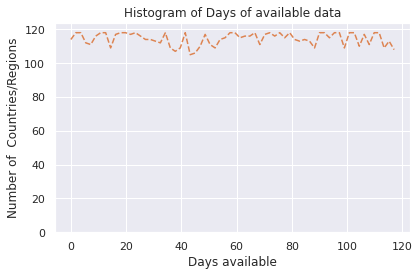

In [0]:

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(bins, len(counts)-1, density=1)

# add a 'best fit' line
ax.plot(bins, counts, '--')
ax.set_xlabel('Days available')
ax.set_ylabel('Number of  Countries/Regions')
ax.set_title(r'Histogram of Days of available data')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

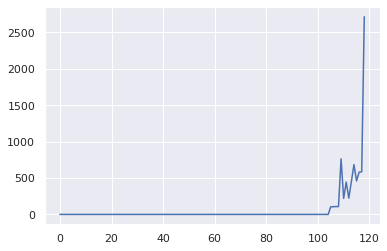

In [0]:
record_avail = []
for available_days in range(len(records_bin_counts)):
  number_of_countries_with_respect_to_available_days = records_bin_counts[available_days]
  number_of_records_available = available_days * number_of_countries_with_respect_to_available_days
  record_avail.append(number_of_records_available)
plt.plot(record_avail)


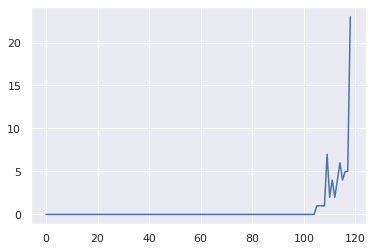

In [0]:
plt.plot(records_bin_counts)

In [0]:
n = [[country, len(original_data[original_data['countriesAndTerritories'] == country ])] for country in original_data['countriesAndTerritories'].unique()]
n = np.array(n).T
n = pd.DataFrame({
    'c' : n[0],
    'count' : np.array(n[1], dtype=np.int32)
})

print(n.head())


                          c  count
0                   Vietnam    114
1  United_States_of_America    118
2            United_Kingdom    118
3      United_Arab_Emirates    112
4                  Thailand    111


Optimal number of days to choose from the dataset:
     days  records
104   104     6864


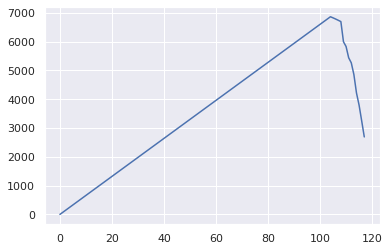

In [0]:
dataset_lengths = []
for days in range(max_days):
  number_of_countries = n[n['count'] > days]['count'].count()
  dataset_lengths.append([days, days*number_of_countries])

dataset_lengths = np.array(dataset_lengths).T
dataset_lengths = pd.DataFrame({
    'days' : dataset_lengths[0],
    'records' : np.array(dataset_lengths[1], dtype=np.int32)
})

plt.plot(dataset_lengths['records'])

print('Optimal number of days to choose from the dataset:' )
print(dataset_lengths[dataset_lengths['records']==max(dataset_lengths['records'])])

In [0]:
def generate_synthetic_data(sample_dataset,run_id, window = 0, sythesize_ratio = 2):
    synthetic_data = pd.DataFrame(columns=sample_dataset.columns)
    
    for k in range(sythesize_ratio):
      if len(synthetic_data) >= len(sample_dataset) * sythesize_ratio:
        break;
      #this loop generates a set that resembles the entire dataset
      for country in sample_dataset['countriesAndTerritories'].unique():
        country_sample = sample_dataset[sample_dataset['countriesAndTerritories'] == country]
        country_synthetic = pd.DataFrame(columns=sample_dataset.columns)

        #population data change
        popData2018 = country_sample.iloc[0]['popData2018']
        population_change_percentage = 1+ (np.random.normal(0,1) / 100)
        population_new = np.round(population_change_percentage*popData2018)

        #this loop generates a set that resembles the country sample
        for i in range(len(country_sample)):
            country_synthetic_temp = pd.DataFrame(columns=sample_dataset.columns)
            beam = country_sample.iloc[i:i+window]
            
            #generate random variables
            mean_cases = np.mean(beam['cases'].to_numpy())
            std_cases = np.std(beam['cases'].to_numpy())
            std_deaths = np.std(beam['deaths'].to_numpy())
            mean_deaths = np.mean(beam['deaths'].to_numpy())

            country_synthetic_temp['cases'] = pd.Series(np.round(max(0,np.random.normal(mean_cases, std_cases))))
            country_synthetic_temp['deaths'] = pd.Series(np.round(max(0,np.random.normal(mean_deaths, std_deaths))))

            country_synthetic_temp['popData2018'] = pd.Series(population_new)

            country_synthetic_temp['countriesAndTerritories'] = pd.Series(beam['countriesAndTerritories'].tolist())
            country_synthetic_temp['geoId'] = pd.Series(beam['geoId'].tolist())
            country_synthetic_temp['countryterritoryCode'] = pd.Series(beam['countryterritoryCode'].tolist())
            country_synthetic_temp['continentExp'] = pd.Series(beam['continentExp'].tolist())
            
            country_synthetic = country_synthetic.append(country_synthetic_temp, ignore_index=True)
        synthetic_data = synthetic_data.append(country_synthetic, ignore_index=True)
    synthetic_data.insert(len(synthetic_data.columns), "syn_iter", run_id)
    return synthetic_data

In [0]:
#testing for accuracy
def verify_synthetic_data(synthetic_data,original_data, print_results = False):
  countryterritoryCode ='CN'
  #test_synthetic_data = synthetic_data[synthetic_data['countryterritoryCode'] == countryterritoryCode]
  test_synthetic_data = synthetic_data
  control_set = original_data #[original_data['countryterritoryCode']==countryterritoryCode]
  case_mean = np.mean(control_set['cases'].to_numpy()) - np.mean(test_synthetic_data['cases'].to_numpy())
  death_mean = np.mean(control_set['deaths'].to_numpy()) - np.mean(test_synthetic_data['deaths'].to_numpy())
  pop_mean = np.mean(control_set['popData2018'].to_numpy()) - np.mean(test_synthetic_data['popData2018'].to_numpy())

  case_std = np.std(control_set['cases'].to_numpy()) - np.mean(test_synthetic_data['cases'].to_numpy())
  death_std = np.std(control_set['deaths'].to_numpy()) - np.mean(test_synthetic_data['deaths'].to_numpy())
  pop_std = np.std(control_set['popData2018'].to_numpy()) - np.mean(test_synthetic_data['popData2018'].to_numpy())

  if print_results:
    print(test_synthetic_data.head())
    print(control_set.head())
    print('original data length : ', len(control_set))
    print('synthetic data length : ',len(test_synthetic_data))
    print('min sequence length : ',min([len(test_synthetic_data[test_synthetic_data['countryterritoryCode']==country]) for country in test_synthetic_data['countryterritoryCode'].unique()]))
    print('max sequence length : ',max([len(test_synthetic_data[test_synthetic_data['countryterritoryCode']==country]) for country in test_synthetic_data['countryterritoryCode'].unique()]))

    print('Mean diff. cases : ', np.mean(control_set['cases'].to_numpy()) - np.mean(test_synthetic_data['cases'].to_numpy()))
    print('Mean diff. deaths : ', np.mean(control_set['deaths'].to_numpy()) - np.mean(test_synthetic_data['deaths'].to_numpy()))
    print('Mean diff. population : ', np.mean(control_set['popData2018'].to_numpy()) - np.mean(test_synthetic_data['popData2018'].to_numpy()))
  
  return  [case_mean, death_mean, pop_mean, case_std , death_std , pop_std ]

In [0]:
 results = []
 for i in range(2,20):
   syn_data = generate_synthetic_data(original_data,i, sythesize_ratio = 1)
   print('window :', i, ' len :', len(syn_data))
   results.append(verify_synthetic_data(syn_data,original_data))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


ZeroDivisionError: ignored

In [0]:
results_arr = np.array(results)
print(results_arr.shape)
cases_mu_std = results_arr.T[[0,3]]
deaths_mu_std =  results_arr.T[[1,4]]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
axes[0].plot((cases_mu_std[0]-np.mean(cases_mu_std[0]))/np.std(cases_mu_std[0]))
axes[0].set_title('"Cases" difference in mean')
axes[0].set_xlabel('Window size')

axes[1].plot((cases_mu_std[1]-np.mean(cases_mu_std[1]))/np.std(cases_mu_std[1]))
axes[1].set_title('Diff. in std. deviation')
axes[1].set_xlabel('Window size')

ratio = cases_mu_std[1]/cases_mu_std[0]
ratio = (ratio - np.mean(ratio) )/  np.std(ratio)

axes[2].plot(ratio)
axes[2].set_title('Ratio between  std. dev/ dif. in mean')
axes[2].set_xlabel('Window size')

fig.tight_layout()

(0,)


IndexError: ignored

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
axes[0].plot((deaths_mu_std[0]-np.mean(deaths_mu_std[0]))/np.std(deaths_mu_std[0]))
axes[0].set_title('"Deaths" difference in mean')
axes[0].set_xlabel('Window size')

axes[1].plot((deaths_mu_std[1]-np.mean(deaths_mu_std[1]))/np.std(deaths_mu_std[1]))
axes[1].set_title('Diff. in std. deviation')
axes[1].set_xlabel('Window size')

ratio = deaths_mu_std[1]/deaths_mu_std[0]
ratio = (ratio - np.mean(ratio) )/  np.std(ratio)

axes[2].plot(ratio)
axes[2].set_title('Ratio between  std. dev/ dif. in mean')
axes[2].set_xlabel('Window size')

fig.tight_layout()

In [0]:
run_id = 2842000 #ddmyyhh
for i in range(50):
  rand_number = np.random.normal(0,1)
  if rand_number >= 0:
    rand_number =1
  else:
    rand_number =0
  window_size = rand_number*(15 + np.round(np.random.normal(0,1))) + (1 - rand_number)*(4 + np.round(np.random.normal(0,1)))
  synthetic_data = generate_synthetic_data(original_data, run_id = str(i)+str(run_id), window = int(window_size), sythesize_ratio = 10)
  synthetic_data.to_csv(PATH+'/input/raw/synthetic/synthetic_'+str(i)+'_dt27_04_'+str(int(window_size))+'.csv',  index=False )
  print('synth step : ', i, ' len : ', len(synthetic_data))

In [0]:
run_id = 2842001 #ddmyyhh
for i in range(50):
  window_size = 9 + np.around(np.round(np.random.normal(0,1)))
  synthetic_data = generate_synthetic_data(original_data, run_id = str(i)+str(run_id), window = int(window_size), sythesize_ratio = 10)
  synthetic_data.to_csv(PATH+'/input/raw/synthetic/synthetic_'+str(i)+'_'+str(run_id)+'_dt27_04_'+str(int(window_size))+'.csv',  index=False )
  print('synth step : ', i, ' len : ', len(synthetic_data))

synth step :  27  len :  75520


KeyboardInterrupt: ignored